In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [92]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})



In [93]:
import examples.corrosion2d1pit.configs as cfg
from examples.corrosion2d1pit.model import PINN


cfg = cfg.Config()
pinn = PINN(config=cfg)
fnames = os.listdir(f"{cfg.DATA_PATH}/")
fnames = [fname for fname in fnames if "sol" in fname]
ts = [float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames]
ts = jnp.array(ts)
ts = ts[ts<cfg.DOMAIN[-1][1] * cfg.Tc]

In [94]:
ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/autodl-tmp/tf-logs/corrosion/2d-1pit/irr/baseline-30s-2/model-2500/")
state_noirr = ckpt.restore("/root/autodl-tmp/tf-logs/corrosion/2d-1pit/noirr/baseline-30s/model-2500/")
params = state["params"]
params_noirr = state_noirr["params"]

In [96]:
pred_radius = []
pred_radius_noirr = []
fem_radius = []
# analytic_radius = []
skip_every = 1


def compute_radius(sol: jnp.ndarray):
    area_fraction = jnp.mean(jnp.where(sol < 0.5, 1, 0))
    r = jnp.sqrt(area_fraction / jnp.pi)
    return r * cfg.Lc

fnames = os.listdir(f"{cfg.DATA_PATH}/")
fnames = [fname for fname in fnames if "sol" in fname]
ts = jnp.array([float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames])
ts = ts[ts<cfg.DOMAIN[-1][1] * cfg.Tc]
ts = ts.sort()

# ts = jnp.arange(0, 5.1, 0.1)
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy")[::skip_every] / cfg.Lc
for idx, tic in enumerate(ts):
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
    # pred = vmap(pinn.net_u, in_axes=(None, 0, 0))(params, mesh, t)
    # pred_noirr = vmap(pinn.net_u, in_axes=(None, 0, 0))(params_noirr, mesh, t)
    pred = vmap(
        lambda params, mesh, t: pinn.net_u(params, mesh, t)[0],
        in_axes=(None, 0, 0),
    )(params, mesh, t)
    pred_noirr = vmap(
        lambda params, mesh, t: pinn.net_u(params, mesh, t)[0],
        in_axes=(None, 0, 0),
    )(params_noirr, mesh, t)
    
    ref_sol = jnp.load(f"{cfg.DATA_PATH}/sol-{tic:.3f}.npy")[::skip_every][:, 0]
    pred_radius.append(compute_radius(pred))
    pred_radius_noirr.append(compute_radius(pred_noirr))
    fem_radius.append(compute_radius(ref_sol))

pred_radius = jnp.array(pred_radius)
pred_radius_noirr = jnp.array(pred_radius_noirr)
fem_radius = jnp.array(fem_radius)

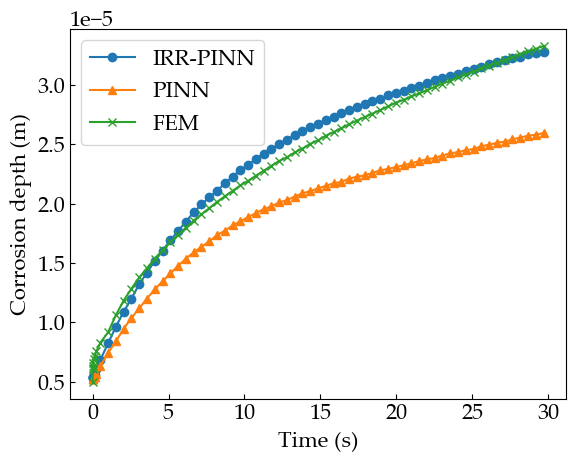

In [99]:
%matplotlib inline
fig, ax = plt.subplots()

# ts = jnp.sqrt(ts)

ax.plot(ts, pred_radius, label="IRR-PINN", marker="o")
ax.plot(ts, pred_radius_noirr, label="PINN", marker="^")
ax.plot(ts, fem_radius, label="FEM", marker="x")
# ax.plot(ts, analytic_radius, label="Analytic", marker="s")

# put the formulation of the analytic solution
# ax.text(0.9, 0.5, r"$R(t) = R_0 - \lambda t$", transform=ax.transAxes, ha="right")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Corrosion depth (m)")

ax.legend()

# plt.savefig("figures/corrosion2d1pit-radius.png", dpi=300, bbox_inches="tight")


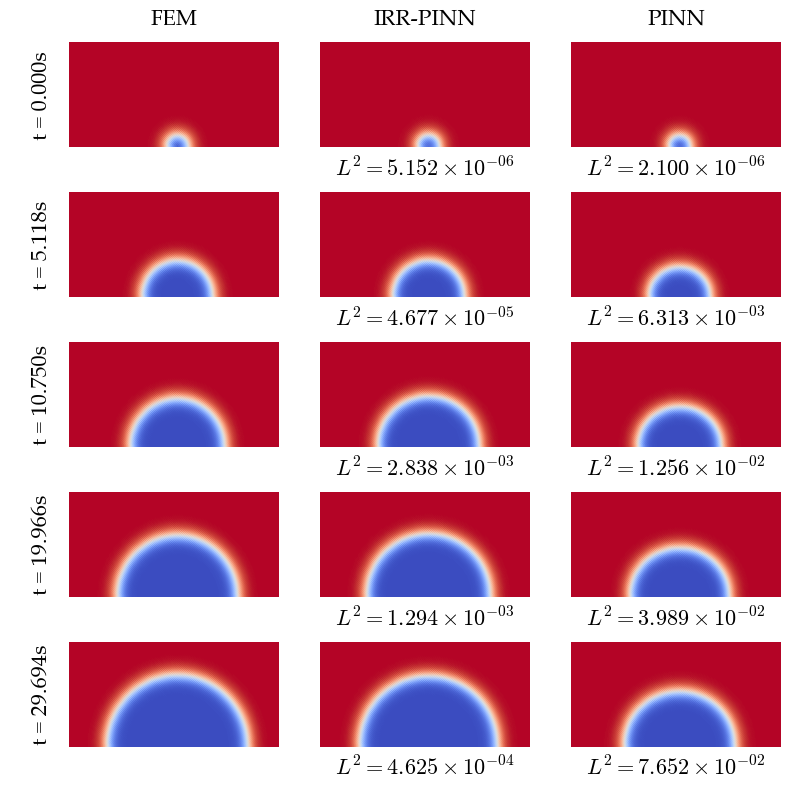

In [100]:
ts = [0.000, 5.118, 10.750, 19.966, 29.694]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(1+len(ts)*2, 4, height_ratios=[0.2] + [1, 0.2,]*len(ts), width_ratios=[0.1] + [1]*3)

col_names = ["", "FEM", "IRR-PINN", "PINN"]
for i, col_name in enumerate(col_names):
    ax = fig.add_subplot(gs[0, i])
    ax.text(0.5, 0.0, col_name, ha="center", va="bottom",
            transform=ax.transAxes, rotation=0)
    ax.axis("off")
    
    
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy")[::skip_every] / cfg.Lc
for i, tic in enumerate(ts):
    
    ax = fig.add_subplot(gs[1+2*i, 0])
    ax.text(1.0, 0.5, f"t = {tic:.3f}s", ha="left", va="center",
            transform=ax.transAxes, rotation=90)
    ax.axis("off")
    
    
    
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
    pred = vmap(
        lambda params, mesh, t: pinn.net_u(params, mesh, t)[0],
        in_axes=(None, 0, 0),
    )(params, mesh, t)
    pred_noirr = vmap(
        lambda params, mesh, t: pinn.net_u(params, mesh, t)[0],
        in_axes=(None, 0, 0),
    )(params_noirr, mesh, t)
    ref_sol = jnp.load(f"{cfg.DATA_PATH}/sol-{tic:.3f}.npy")[::skip_every][:, 0]
    
    def plot_sol(ax, mesh, sol):
        ax.scatter(
            mesh[:, 0], mesh[:, 1], c=sol, cmap="coolwarm", vmin=0, vmax=1, edgecolors="none"
        )
        ax.set_aspect("equal")
        ax.set_axis_off()
        ax.set(xlim=(-0.5, 0.5), ylim=(0, 0.5))
        
    def plot_error(ax, ref, sol):
        error = jnp.mean((ref - sol) ** 2)
        error_str = "$L^2=" + f"{error:.3e}".replace("e", r"\times 10^{") + "}$"
        ax.text(0.5, 0.5, error_str, ha="center", va="center",
                transform=ax.transAxes, rotation=0)
        ax.axis("off")
        

    ax = fig.add_subplot(gs[1+2*i, 1])
    plot_sol(ax, mesh, ref_sol)
    ax = fig.add_subplot(gs[1+2*i, 2])
    plot_sol(ax, mesh, pred)
    ax = fig.add_subplot(gs[1+2*i, 3])
    plot_sol(ax, mesh, pred_noirr)
    
    ax = fig.add_subplot(gs[2+2*i, 2])
    plot_error(ax, ref_sol, pred)
    
    ax = fig.add_subplot(gs[2+2*i, 3])
    plot_error(ax, ref_sol, pred_noirr)
    
# plt.savefig("figures/corrosion2d1pit-sol.png", dpi=300, bbox_inches="tight")

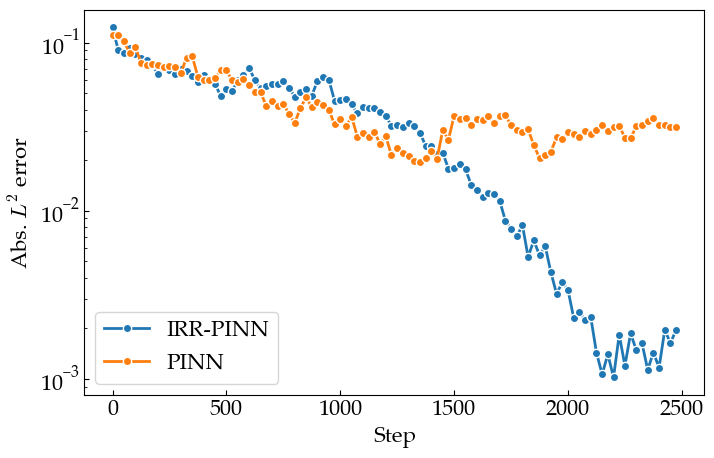

In [101]:
import pandas as pd

error_log = pd.read_csv("./logs-eval/run-corrosion_2d-1pit_irr_baseline-30s-2-tag-error_error.csv")
error_log_noirr = pd.read_csv("./logs-eval/run-corrosion_2d-1pit_noirr_baseline-30s-tag-error_error.csv")

error_log = error_log[error_log["Step"] < 2500]
error_log_noirr = error_log_noirr[error_log_noirr["Step"] < 2500]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(error_log["Step"], error_log["Value"], label="IRR-PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(error_log_noirr["Step"], error_log_noirr["Value"], label="PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Abs. $L^2$ error", xlabel="Step", yscale="log")
ax.legend(loc="lower left",)
# plt.savefig("figures/corrosion2d1pit-error-log.png", dpi=300, bbox_inches="tight")

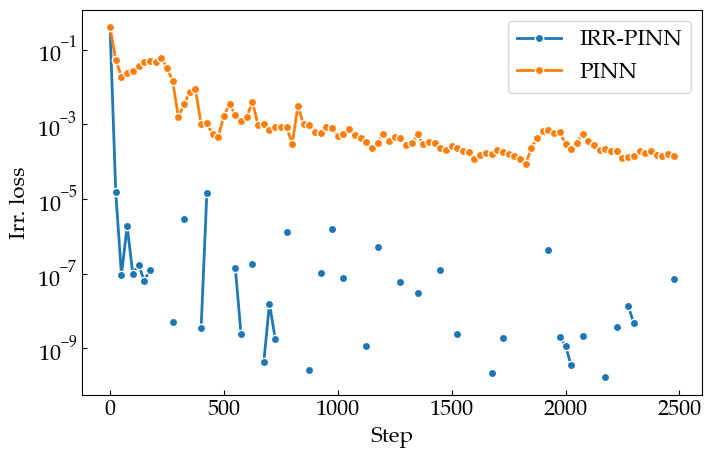

In [102]:
loss_log = pd.read_csv("./logs-eval/run-corrosion_2d-1pit_irr_baseline-30s-2-tag-loss_irr.csv")
loss_log_noirr = pd.read_csv("./logs-eval/run-corrosion_2d-1pit_noirr_baseline-30s-tag-loss_irr.csv")


loss_log["Value"] = loss_log["Value"].apply(lambda x : jnp.nan if jnp.abs(x) < 1e-10 else x)
loss_log = loss_log[loss_log["Step"] < 2500]
loss_log_noirr = loss_log_noirr[loss_log_noirr["Step"] < 2500]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(loss_log["Step"], loss_log["Value"], label="IRR-PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(loss_log_noirr["Step"], loss_log_noirr["Value"], label="PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Irr. loss", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
# plt.savefig("figures/corrosion2d1pit-irrloss-log.png", dpi=300, bbox_inches="tight")

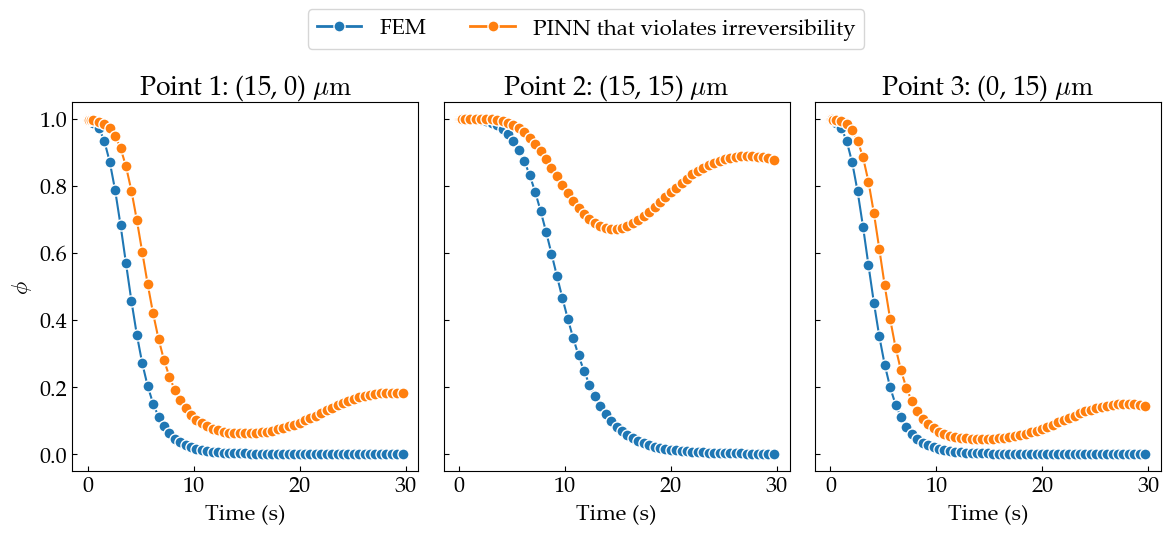

In [104]:
points = [jnp.array([0.15, 0.]), jnp.array([0.15, 0.15]), jnp.array([0.0, 0.15])]
state_typical_error = ckpt.restore("/root/autodl-tmp/tf-logs/corrosion/2d-1pit/noirr/baseline-30s/model-200/")
params_typical_error = state_typical_error["params"]

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True,)

for pt_idx, (ax, pt) in enumerate(zip(axes, points)):

    fem_phi = []
    distances = jnp.linalg.norm(mesh - pt, axis=1)
    closest_index = jnp.argmin(distances)
    closest_pt = mesh[closest_index]

    fnames = os.listdir(f"{cfg.DATA_PATH}/")
    fnames = [fname for fname in fnames if "sol" in fname]
    ts = jnp.array([float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames])
    ts = ts[ts<cfg.DOMAIN[-1][1] * cfg.Tc]
    ts = ts.sort()

    for idx, tic in enumerate(ts):
        ref_phi = jnp.load(f"{cfg.DATA_PATH}/sol-{tic:.3f}.npy")[closest_index, 0]
        fem_phi.append(ref_phi)

    mesh_inp = jnp.repeat(closest_pt[None, :], ts.shape[0], axis=0)
    ax.plot(ts, jnp.array(fem_phi), label="FEM", marker="o", 
            markeredgecolor="white", markersize=8, markeredgewidth=1)
    

    pred_phi_typical_error = vmap(
        lambda params, mesh, t: pinn.net_u(params, mesh, t)[0],
        in_axes=(None, 0, 0),
    )(params_typical_error, mesh_inp, ts.reshape(-1, 1) / cfg.Tc)
    ax.plot(ts, pred_phi_typical_error, label="PINN (typical error)", marker="o",
            markeredgecolor="white", markersize=8, markeredgewidth=1)
    ax.set_xlabel("Time (s)")
    ax.set_title(rf"Point {pt_idx+1}: ({int(pt[0]*100)}, {int(pt[1]*100)}) $\mathrm{{\mu m}}$")


# manually set legend for two lines
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='C0', marker='o', markeredgecolor="white", markersize=8, markeredgewidth=1, lw=2),
    Line2D([0], [0], color='C1', marker='o', markeredgecolor="white", markersize=8, markeredgewidth=1, lw=2),
]

fig.legend(custom_lines, ["FEM", "PINN that violates irreversibility"], 
           loc='upper center', 
           ncol=2, bbox_to_anchor=(0.5, 1.1), fontsize=16)


axes[0].set_ylabel(r"$\phi$")
fig.tight_layout()
fig.savefig("figures/corrosion2d1pit-irr-violation.png", dpi=300, bbox_inches="tight")

In [35]:
ts.shape

(66,)

In [10]:
pred_radius = []
pred_radius_noirr = []
fem_radius = []
# analytic_radius = []
skip_every = 1


def compute_radius(sol: jnp.ndarray):
    area_fraction = jnp.mean(jnp.where(sol < 0.5, 1, 0))
    r = jnp.sqrt(area_fraction / jnp.pi)
    return r * cfg.Lc

fnames = os.listdir(f"{cfg.DATA_PATH}/")
fnames = [fname for fname in fnames if "sol" in fname]
ts = jnp.array([float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames])
ts = ts[ts<cfg.DOMAIN[-1][1] * cfg.Tc]
ts = ts.sort()

ret = jnp.zeros(ts.shape[0])
ret_ref = jnp.zeros(ts.shape[0])
ret_f = jnp.zeros(ts.shape[0])
# ts = jnp.arange(0, 5.1, 0.1)
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy")[::skip_every] / cfg.Lc
for idx, tic in enumerate(ts):
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc

    pred = vmap(
        lambda params, mesh, t: pinn.net_u(params, mesh, t),
        in_axes=(None, 0, 0),
    )(params, mesh, t)

    c = pred[:, 1]
    phi = pred[:, 0]
    cse = pinn.cfg.CSE
    cle = pinn.cfg.CLE
    h_phi = -2 * phi**3 + 3 * phi**2
    cs = c + (1-h_phi) * (cse - cle)
    cl = c - h_phi * (cse - cle)
    ret = ret.at[idx].set(jnp.mean(cs + cl))

    ref = jnp.load(f"{cfg.DATA_PATH}/sol-{tic:.3f}.npy")[::skip_every]
    c_ref = ref[:, 1]
    phi_ref = ref[:, 0]
    cse_ref = pinn.cfg.CSE
    cle_ref = pinn.cfg.CLE
    h_phi_ref = -2 * phi_ref**3 + 3 * phi_ref**2
    cs_ref = c_ref + (1-h_phi_ref) * (cse_ref - cle_ref)
    cl_ref = c_ref - h_phi_ref * (cse_ref - cle_ref)
    ret_ref = ret_ref.at[idx].set(jnp.mean(cs_ref + cl_ref))




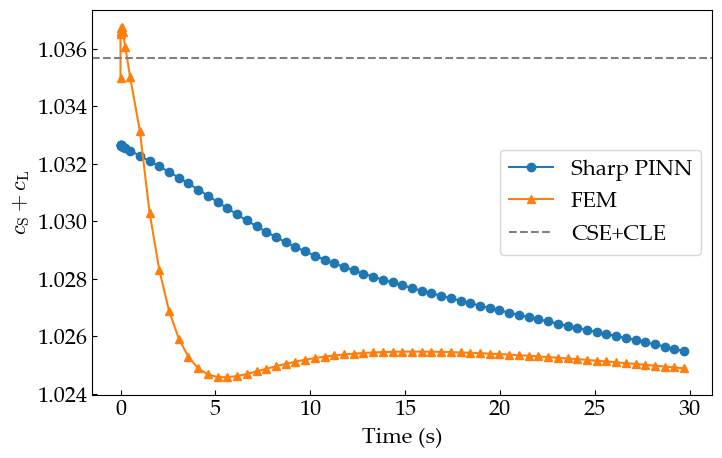

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ts, ret, label="Sharp PINN", marker="o")
ax.plot(ts, ret_ref, label="FEM", marker="^")
ax.axhline(y=pinn.cfg.CSE + pinn.cfg.CLE, color="gray", linestyle="--", label="CSE+CLE")
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"$c_\mathrm{S} + c_\mathrm{L}$")
ax.legend()

In [15]:

def compute_f(x, t):
    cse = pinn.cfg.CSE
    cle = pinn.cfg.CLE
    AA = pinn.cfg.AA
    alphaphi = pinn.cfg.ALPHA_PHI
    omegaphi = pinn.cfg.OMEGA_PHI
    phi, c = pinn.net_u(params, x, t)
    nabla_phi = jax.jacrev(
        lambda x, t: pinn.net_u(params, x, t)[0], argnums=0
    )(x, t) / cfg.Lc

    h_phi = -2 * phi**3 + 3 * phi**2
    g_phi = phi**2 * (1-phi)**2

    cs = c + (1-h_phi) * (cse - cle)
    cl = c - h_phi * (cse - cle)
    fs = AA * (cs - cse) ** 2
    fl = AA * (cl - cle) ** 2
    f = h_phi*fs + (1-h_phi)*fl + omegaphi * g_phi +  alphaphi / 2 * jnp.sum(nabla_phi**2, axis=-1)
    
    # term1 = pinn.cfg.AA * (
    #     c - h_phi * (cse-cle) - cle
    # ) ** 2
    # term2 = pinn.cfg.OMEGA_PHI * g_phi
    # term3 = pinn.cfg.ALPHA_PHI / 2 * jnp.sum(nabla_phi**2, axis=-1)
    # f =  term1 + term2 + term3
    return f

# analytic_radius = []
skip_every = 1

fnames = os.listdir(f"{cfg.DATA_PATH}/")
fnames = [fname for fname in fnames if "sol" in fname]
ts = jnp.array([float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames])
ts = ts[ts<cfg.DOMAIN[-1][1] * cfg.Tc]
ts = ts.sort()

ret_f = jnp.zeros(ts.shape[0])
ret_df_dt = jnp.zeros(ts.shape[0])
# ts = jnp.arange(0, 5.1, 0.1)
# mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy")[::skip_every] / cfg.Lc
xlim = (-0.5, 0.5)
ylim = (0, 0.5)
xx = jnp.linspace(xlim[0], xlim[1], 60)
yy = jnp.linspace(ylim[0], ylim[1], 30)
xx, yy = jnp.meshgrid(xx, yy)
mesh = jnp.stack([xx.ravel(), yy.ravel()], axis=-1).reshape(-1, 2)
for idx, tic in enumerate(ts):
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
    f = vmap(compute_f, in_axes=(0, 0))(mesh, t)
    
    # 将f重新reshape为网格形状
    f_grid = f.reshape(30, 60)  # (ny, nx)
    
    # 计算积分区域的面积元素
    dx = (xlim[1] - xlim[0]) / (60 - 1) * cfg.Lc
    dy = (ylim[1] - ylim[0]) / (30 - 1) * cfg.Lc
    
    # 使用梯形公式进行二维积分
    integral = jnp.trapezoid(jnp.trapezoid(f_grid, dx=dy, axis=0), dx=dx)
    
    ret_f = ret_f.at[idx].set(integral)


Text(0, 0.5, '$f$')

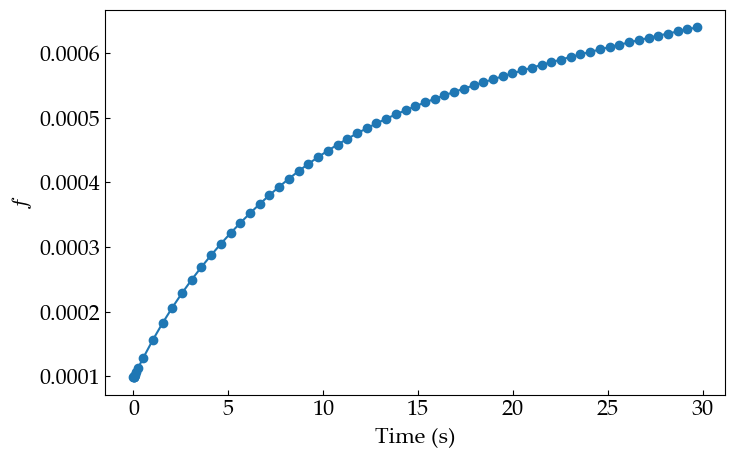

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ts, ret_f, label="Sharp PINN (f)", marker="o")
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"$f$")

/tmp/ipykernel_1990/2264583293.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax.scatter(mesh[:, 0], mesh[:, 1], cmap="coolwarm", vmin=0, vmax=1, edgecolors="none")


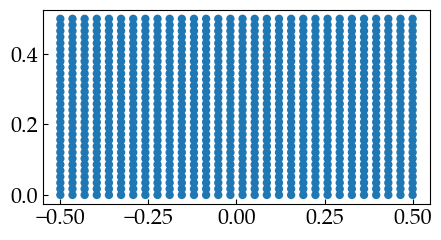

In [56]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(mesh[:, 0], mesh[:, 1], cmap="coolwarm", vmin=0, vmax=1, edgecolors="none")
ax.set_aspect("equal")